In [2]:
import sys
sys.executable

'/Users/rafaellopez/Desktop/DS3/tactical-viewer-app/.venv/bin/python'

In [3]:
%pip install pandas numpy matplotlib seaborn

You should consider upgrading via the '/Users/rafaellopez/Desktop/DS3/tactical-viewer-app/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.__version__

'2.3.3'

In [5]:
from pathlib import Path
Path("../data/raw").resolve()

PosixPath('/Users/rafaellopez/Desktop/DS3/tactical-viewer-app/data/raw')

In [6]:
from pathlib import Path
EVENT_DIR = Path("../data/raw/event_data")
list(EVENT_DIR.iterdir())

[PosixPath('../data/raw/event_data/3812.json')]

In [7]:
import json

event_file = EVENT_DIR / "3812.json"

with open(event_file, "r") as f:
    event_data = json.load(f)

type(event_data)

list

In [8]:
len(event_data)

2010

In [9]:
event_data[0].keys()

dict_keys(['gameId', 'gameEventId', 'possessionEventId', 'startTime', 'endTime', 'duration', 'eventTime', 'sequence', 'gameEvents', 'initialTouch', 'possessionEvents', 'fouls', 'grades', 'stadiumMetadata', 'homePlayers', 'awayPlayers', 'ball'])

In [10]:
import pandas as pd

# Create base DataFrame with only top-level scalar fields
base_cols = [
    "gameId",
    "gameEventId",
    "startTime",
    "endTime",
    "duration",
    "eventTime",
    "sequence"
]

df_base = pd.DataFrame(event_data)[base_cols]
df_base.head()

game_events_df = pd.json_normalize(event_data, sep="_")[[
    "gameEvents_gameEventType",
    "gameEvents_teamId",
    "gameEvents_teamName",
    "gameEvents_playerId",
    "gameEvents_playerName",
    "gameEvents_period"
]]

game_events_df.head()

df_events = pd.concat([df_base.reset_index(drop=True), game_events_df.reset_index(drop=True)], axis=1)
df_events.head()

df_events["gameEvents_gameEventType"].value_counts().head(10)

gameEvents_gameEventType
OTB              1885
OUT               111
SUB                 8
END                 2
OFF                 2
FIRSTKICKOFF        1
SECONDKICKOFF       1
Name: count, dtype: int64

In [11]:
df_otb = df_events[df_events["gameEvents_gameEventType"] == "OTB"].copy()
df_otb.shape

possession_df = pd.json_normalize(event_data, sep="_")[[
    "possessionEvents_possessionEventType",
    "possessionEvents_passerPlayerId",
    "possessionEvents_passerPlayerName",
    "possessionEvents_receiverPlayerId",
    "possessionEvents_receiverPlayerName",
    "possessionEvents_passOutcomeType",
    "possessionEvents_passType"
]]

possession_df.head()

df_otb_pass = pd.concat(
    [df_otb.reset_index(drop=True), possession_df.reset_index(drop=True)],
    axis=1
)

df_otb_pass.head()

df_passes = df_otb_pass[
    df_otb_pass["possessionEvents_possessionEventType"] == "PA"
].copy()

df_passes.shape

df_passes["possessionEvents_passerPlayerName"].value_counts().head(10)

possessionEvents_passerPlayerName
Youssouf Sabaly      70
Nathan Aké           67
Frenkie de Jong      67
Virgil van Dijk      63
Daley Blind          58
Kalidou Koulibaly    47
Nampalys Mendy       46
Matthijs De Ligt     44
Steven Berghuis      42
Idrissa Gueye        41
Name: count, dtype: int64

In [12]:
df_passes["is_completed"] = df_passes["possessionEvents_passOutcomeType"] == "C"
df_passes["is_completed"].value_counts()
pass_stats = (
    df_passes
    .groupby("possessionEvents_passerPlayerName")
    .agg(
        passes_attempted=("is_completed", "count"),
        passes_completed=("is_completed", "sum")
    )
    .assign(
        completion_rate=lambda x: x["passes_completed"] / x["passes_attempted"]
    )
    .sort_values("passes_attempted", ascending=False)
)

pass_stats.head(10)
pass_stats_filtered = pass_stats[pass_stats["passes_attempted"] >= 20]
pass_stats_filtered.head(5)
[c for c in df_passes.columns if "team" in c.lower()]

['gameEvents_teamId', 'gameEvents_teamName']

	•	High-volume passers (center backs, midfielders) show high completion rates
	•	Lower-volume players tend to have more variable completion
	•	Pass efficiency aligns with positional roles
Dataset contains ~2000 events for match 3812.
Most common event type is OTB (on-the-ball), followed by OUT, SUB, etc.

In [13]:
team_pass_stats = (
    df_passes
    .groupby("gameEvents_teamName")
    .agg(
        passes_attempted=("is_completed", "count"),
        passes_completed=("is_completed", "sum")
    )
    .assign(completion_rate=lambda x: x["passes_completed"] / x["passes_attempted"])
    .sort_values("passes_attempted", ascending=False)
)

team_pass_stats

,passes_attempted,passes_completed,completion_rate
gameEvents_teamName,,,
Netherlands,434,358,0.824885
Senegal,400,326,0.815000


<Axes: title={'center': 'Passes Attempted per Team'}, xlabel='gameEvents_teamName'>

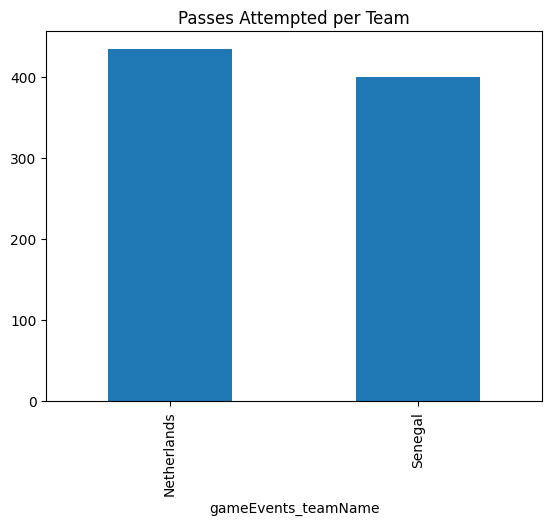

In [14]:
team_pass_stats["passes_attempted"].plot(
    kind="bar",
    title="Passes Attempted per Team"
)

<Axes: title={'center': 'Pass Completion Rate per Team'}, xlabel='gameEvents_teamName'>

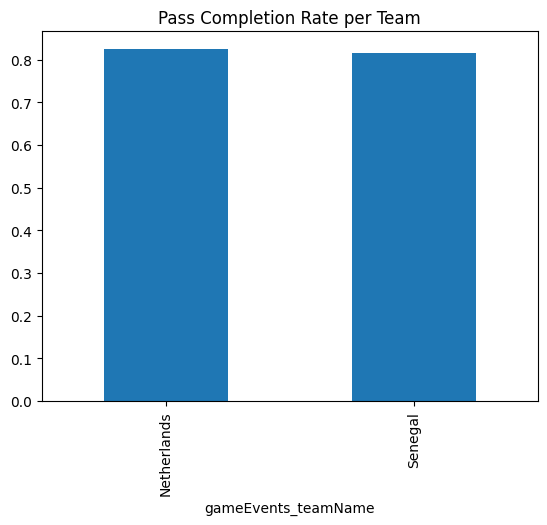

In [15]:
team_pass_stats["completion_rate"].plot(
    kind="bar",
    title="Pass Completion Rate per Team"
)